In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
from glob import glob
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from numpy import expand_dims
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# 0. (Re)create train, test, validation folders

In [3]:
parent_dir = os.getcwd()
try:
    os.mkdir('model_dataset')
except:
    print('DIRECTORY already exists')

for folder in ['train', 'validation', 'test']:
    try:
        path = os.path.join(parent_dir + '/model_dataset', folder) 
        os.mkdir(path)
    except:
        print(folder.upper() + ' FOLDER already exists')
    try:
        if folder == 'train':
            path = os.path.join(parent_dir + '/model_dataset/train', 'augment') 
            os.mkdir(path)
            path = os.path.join(parent_dir + '/model_dataset/train', 'no_augment') 
            os.mkdir(path)
    except:
        print('augment or no_augment FOLDER in TRAIN FOLDER already exists')

# 1. (Re)populate folders with data

In [4]:
def split_train_test(name):
    path = os.getcwd()
    
    # Create class folder in train, validation, test folder
    for folder in ['train', 'validation', 'test']:
        try:
            if folder == 'train':
                if name =='non_spice':
                    path = os.path.join(
                        (parent_dir 
                         + '/model_dataset/train/no_augment'), name)
                    os.mkdir(path)
                else:
                    path = os.path.join(
                        (parent_dir + '/model_dataset/train/augment'), name)
                    os.mkdir(path)
            else:
                path = os.path.join(
                    (parent_dir + '/model_dataset/' + folder), name)
                os.mkdir(path)
        except:
            print('Replacing ' + folder.upper() + ' data for ' + name)
            shutil.rmtree(path)
            if folder == 'train':
                if name == 'non_spice':
                    path = os.path.join(
                        (parent_dir 
                         + '/model_dataset/train/no_augment'), name)
                    os.mkdir(path)
                else:
                    path = os.path.join(
                        (parent_dir + '/model_dataset/train/augment'), name)
                    os.mkdir(path)
            else:
                path = os.path.join(
                    (parent_dir + '/model_dataset/' + folder), name)
                os.mkdir(path)
              
    # Populate with image copies from dataset to model_dataset
    image_files = glob(f"./dataset/{name}/*.jpg")
    train_files, test_files = train_test_split(image_files, test_size=15)
    train_files, val_files = train_test_split(train_files, test_size=15)
    for source in train_files:
        if name == 'non_spice':
            dest = source.replace('dataset', 'model_dataset/train/no_augment')
        else:
            dest = source.replace('dataset', 'model_dataset/train/augment')
        shutil.copy(source,dest)
    for source in test_files:
        dest = source.replace('dataset', 'model_dataset/test')
        shutil.copy(source,dest)
    for source in val_files:
        dest = source.replace('dataset', 'model_dataset/validation')
        shutil.copy(source,dest)

# Loop through the spices and non-spice images
for name in ['dried_basil', 'dried_oregano', 'dried_parsley',
             'dried_thyme', 'non_spice']:
    split_train_test(name)

# 2. Trial and error on image augmentation techniques

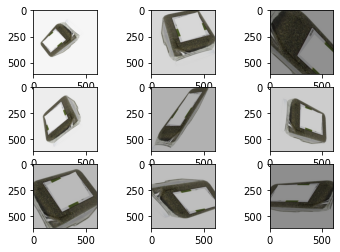

In [6]:
# Initialize sample image
img = load_img('./model_dataset/train/augment/dried_basil/basil1.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)

# Edit ImageDataGenerator to visualize manipulations
datagen = ImageDataGenerator(rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 45,
        zoom_range = 0.5,
        brightness_range= [0.5,1.0],
        fill_mode='nearest')
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# 3. Evaluating image augmentation parameters

## Initialize general generators for training and validation

In [7]:
# Initialize validation generator
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        'model_dataset/validation',
        target_size=(200, 200),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

Found 75 images belonging to 5 classes.


In [8]:
# Combine generators of imbalanced dataset into one
def myGenerator(gen1, gen2):
    while True:
        img_data1,label1 = next(gen1)
        img_data2,label2 = next(gen2)
        if ((label1.shape[0] + label2.shape[0]) % 32) != 0:
            img_data1, label1 = next(gen1)
            img_data2, label2 = next(gen2)
        img_data_c = np.concatenate((img_data1, img_data2))

        label_size = label1.shape[1] + label2.shape[1]
        new_labels1 = np.zeros((label1.shape[0], label_size))
        new_labels1[:, :-label2.shape[1]] = label1
        new_labels2 = np.zeros((label2.shape[0], label_size))
        new_labels2[:, label1.shape[1]:] = label2

        labels_c = np.concatenate((new_labels1, new_labels2), axis=0)

        shuffler = np.random.permutation(labels_c.shape[0])
        labels_c_shuffled = labels_c[shuffler]
        img_data_c_shuffled = img_data_c[shuffler]

        yield img_data_c_shuffled, labels_c_shuffled

In [9]:
# Set up plot styling
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

## Evaluating Low and High Image Augmentation and Batch Size

In [10]:
# Low Image Augmentation, Batch Size of 32
train_datagen = ImageDataGenerator(
        rotation_range=90,
        rescale=1./255,
        fill_mode='nearest')
train_generator_1 = train_datagen.flow_from_directory(
        'model_dataset/train/augment',
        target_size=(200, 200),
        batch_size=26,
        class_mode='categorical', 
        shuffle=True,
        seed=15)
train_generator_2 = train_datagen.flow_from_directory(
        'model_dataset/train/no_augment',
        target_size=(200, 200),
        batch_size=6,
        class_mode='categorical',
        shuffle=True,
        seed=15)
train_generator = myGenerator(train_generator_1, train_generator_2)

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


In [11]:
# Weight Layers: 3 | Activation: Relu | Max Filter: 64 | Max FCN: N/A
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=10,
                    epochs=25, validation_data=valid_generator, 
                    validation_steps=2, verbose=0)

data_acc_df = pd.DataFrame({
    'epoch': [*range(1, len(history.history['accuracy']) + 1)],
    'accuracy': history.history['accuracy']}) 
data_acc_df['Data'] = 'training'
data_vacc_df = pd.DataFrame({
    'epoch':[*range(1, len(history.history['val_accuracy']) + 1)],
    'accuracy':history.history['val_accuracy']})
data_vacc_df['Data'] = 'validation'
data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

plt.figure(figsize=(12, 5))
sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Low Augmentation, Batch Size of 32', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,198,198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Relu (defined at <ipython-input-11-ddf7562b58c2>:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_862]

Function call stack:
train_function


Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


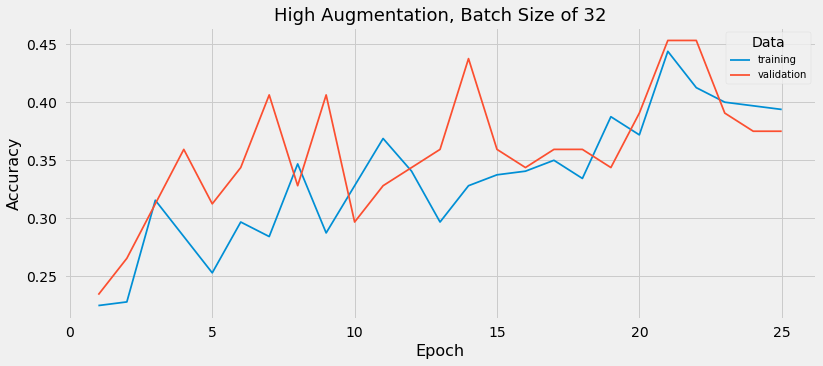

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


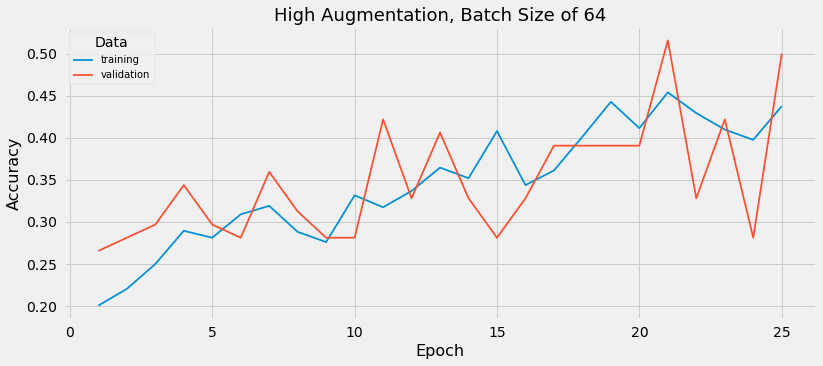

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


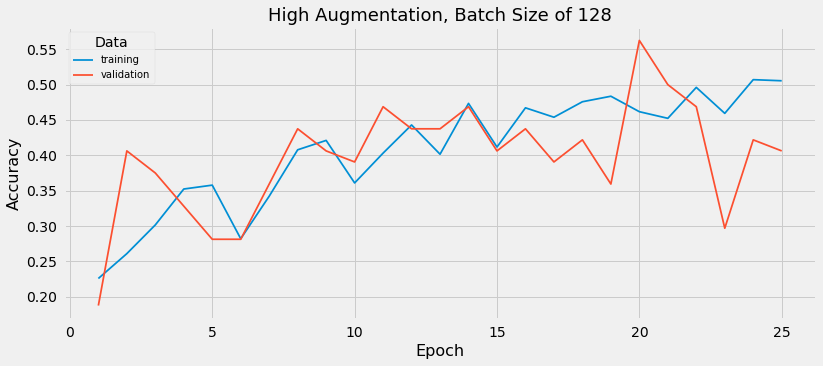

In [ ]:
# High Image Augmentation, Batch Size of 32, 64, 128
batch_spice = [26, 52, 103]
batch_rand = [6, 12, 25]
for b1, b2 in zip(batch_spice, batch_rand):
    train_datagen = ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=45,
            zoom_range=0.5,
            brightness_range=[0.5,1.0],
            rescale=1./255,
            fill_mode='nearest')
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=b1,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=b2,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10,
                        epochs=25, validation_data=valid_generator,
                        validation_steps=2, verbose=0)
    
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']}) 
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1,len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df),axis=0)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('High Augmentation, Batch Size of {}'.format(b1+b2), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Evaluating width_shift_range paramter

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


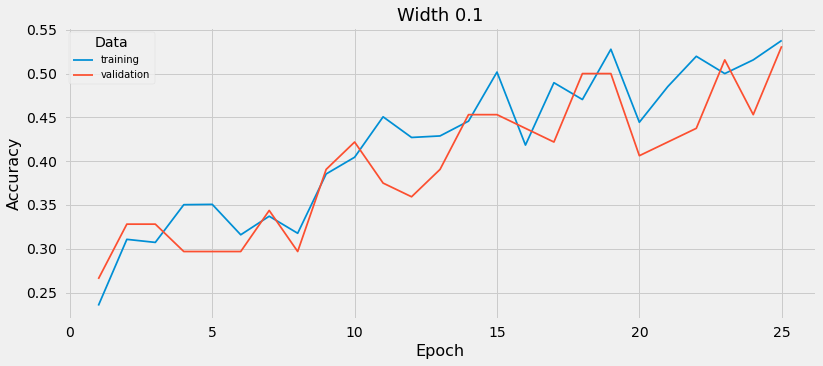

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


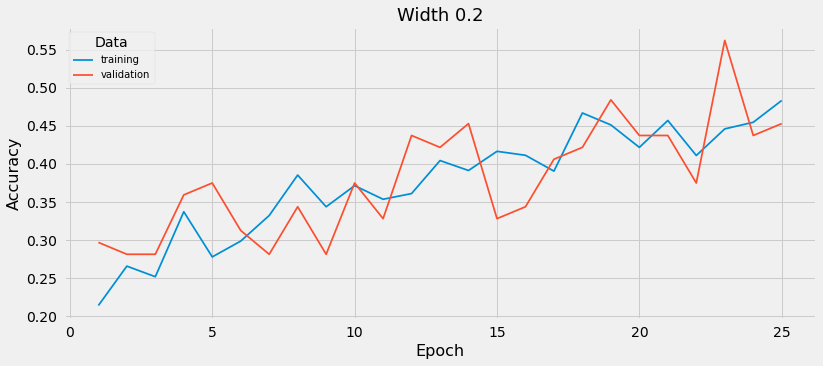

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


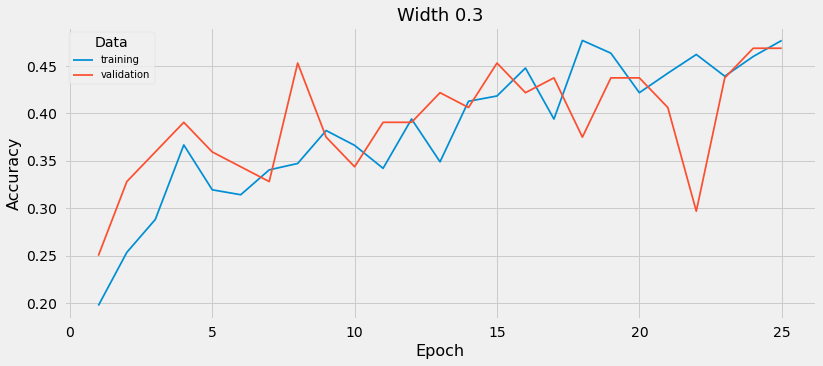

In [ ]:
for width in [0.1, 0.2, 0.3]:
    train_datagen = ImageDataGenerator(
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1./255,
            fill_mode='nearest',
            width_shift_range=width)
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=52,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=12,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5,activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10, 
                        epochs=25, validation_data=valid_generator, 
                        validation_steps=2, verbose=0)
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1,len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']})
        
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1,len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df,data_vacc_df), axis=0)

    plt.figure(figsize=(12,5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Width {}'.format(width), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Evaluating height_shift_range paramter

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


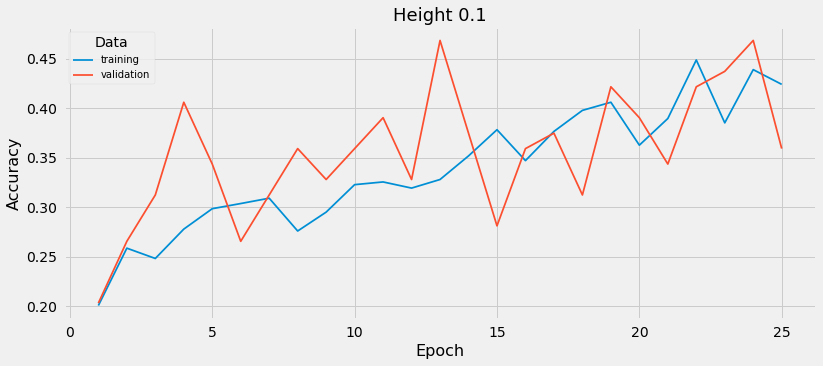

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


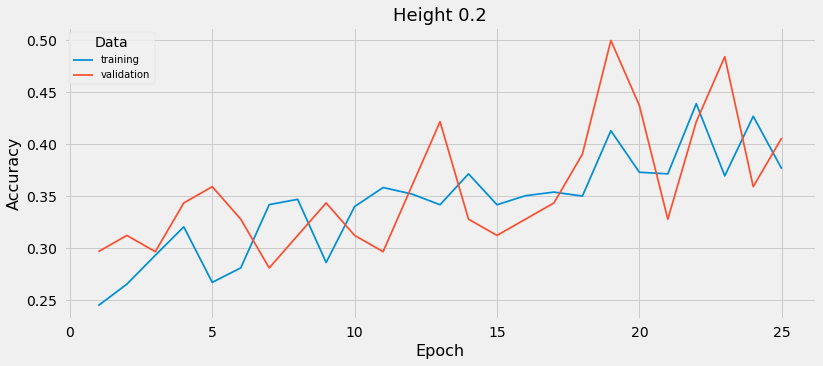

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


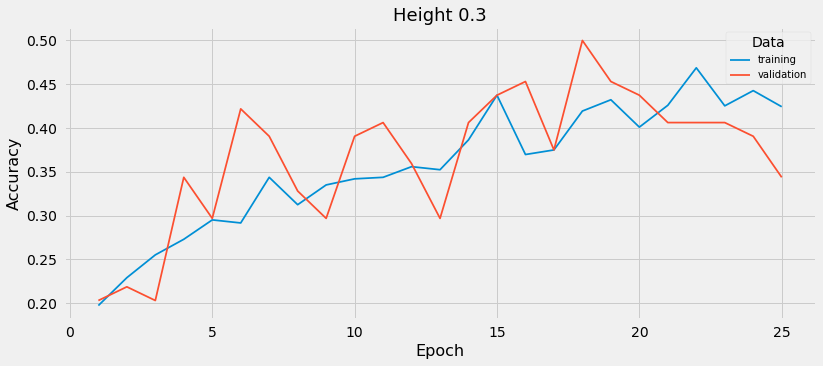

In [ ]:
for height in [0.1, 0.2, 0.3]:
    train_datagen = ImageDataGenerator(
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1./255,
            fill_mode='nearest',
            width_shift_range=0.2,
            height_shift_range=height)
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=52,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=12,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5,activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10, 
                        epochs=25, validation_data=valid_generator,
                        validation_steps=2, verbose=0)
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']})
        
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12,5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Height {}'.format(height), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Evaluating shear_range parameter

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


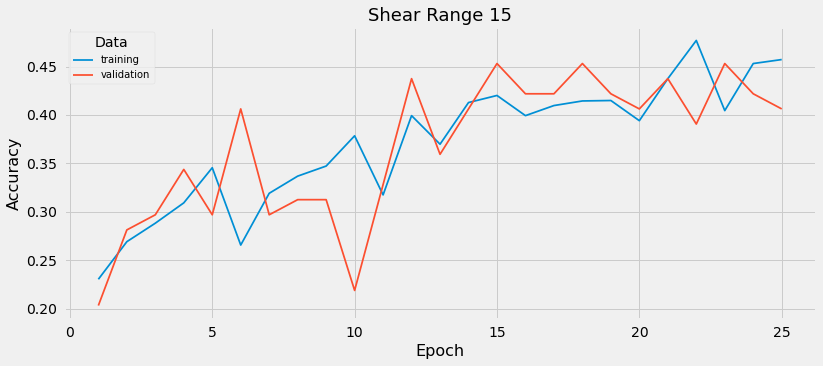

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


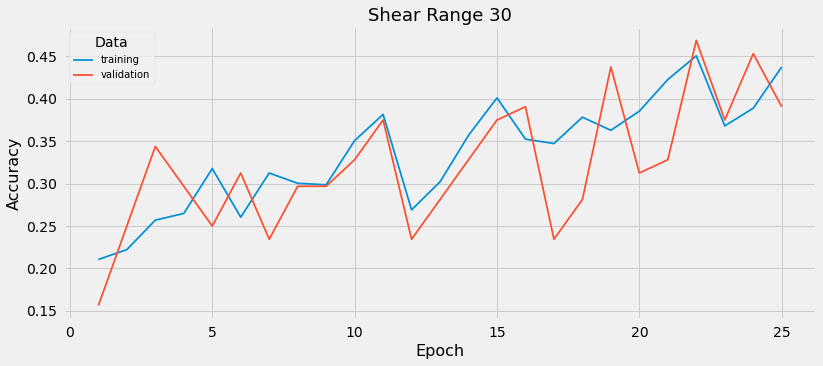

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


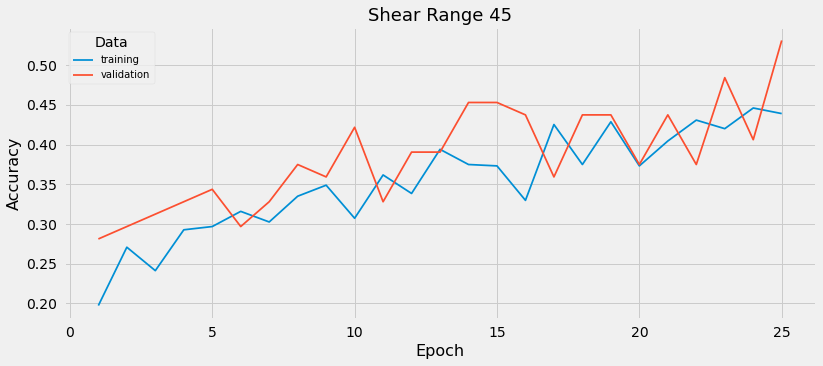

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


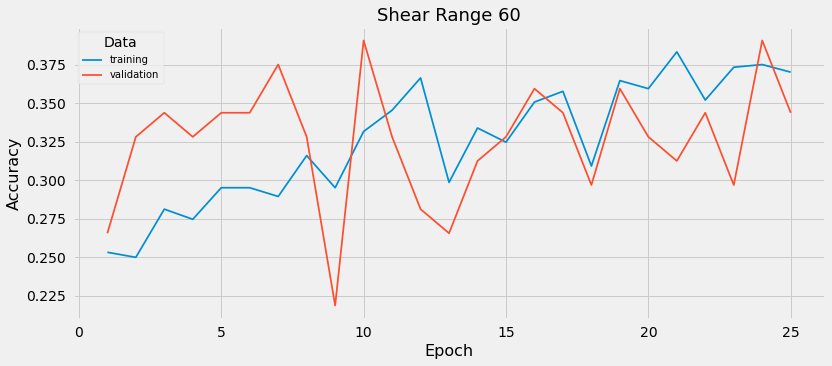

In [ ]:
for shear in [15, 30, 45, 60]:
    train_datagen= ImageDataGenerator(
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1./255,
            fill_mode='nearest',
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=shear)
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=52,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=12,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10,
                        epochs=25, validation_data=valid_generator,
                        validation_steps=2, verbose=0)
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']})
        
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12,5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Shear Range {}'.format(shear), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Evaluating zoom_range parameter

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


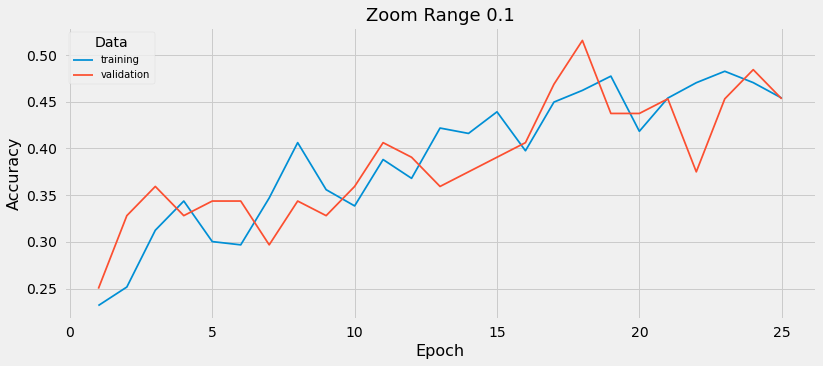

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


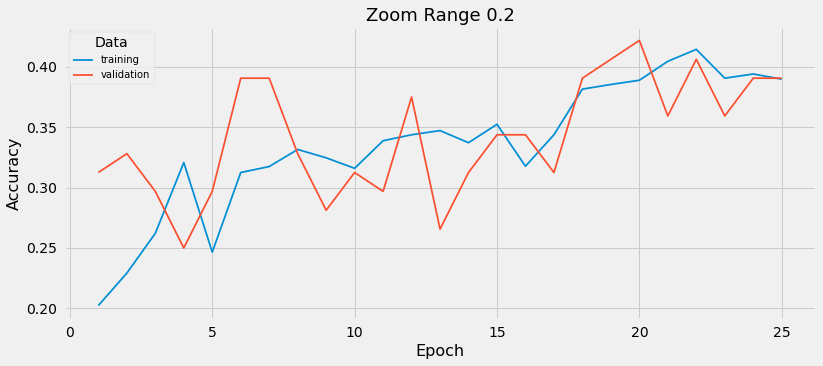

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


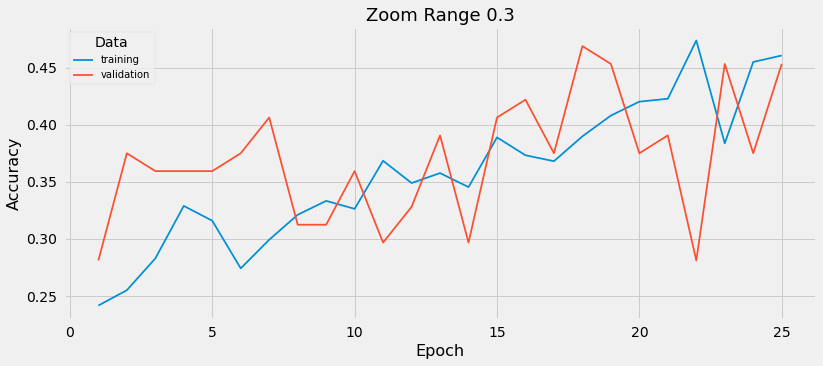

In [ ]:
for zoom in [0.1, 0.2, 0.3]:
    train_datagen = ImageDataGenerator(
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1./255,
            fill_mode='nearest',
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=15,
            zoom_range=zoom)
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=52,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=12,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10,
                        epochs=25, validation_data=valid_generator,
                        validation_steps=2, verbose=0)
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']})
        
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Zoom Range {}'.format(zoom), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Evaluating brightness_range parameter

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


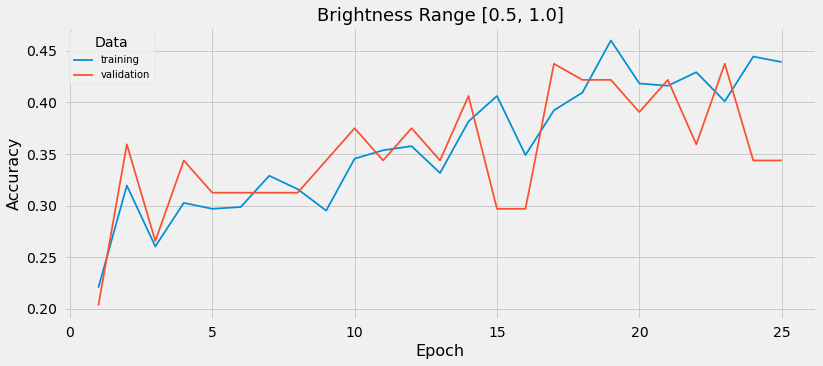

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


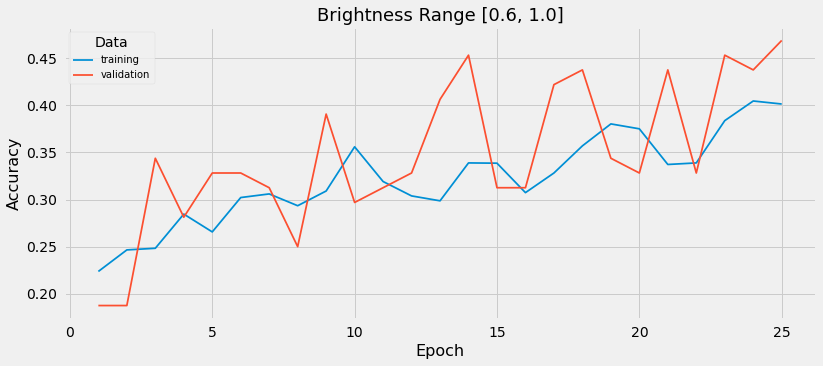

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


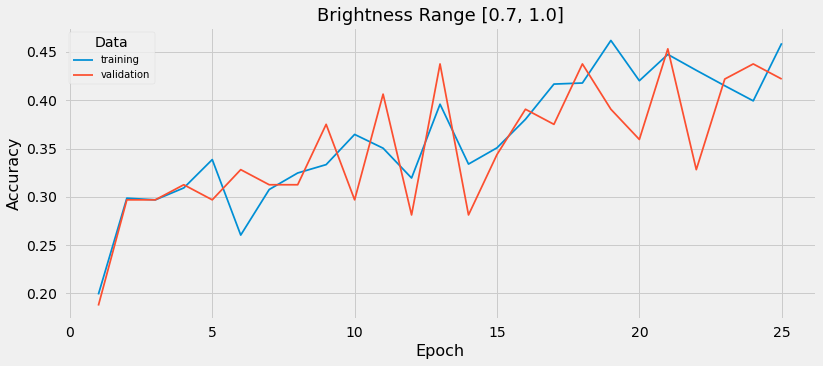

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.


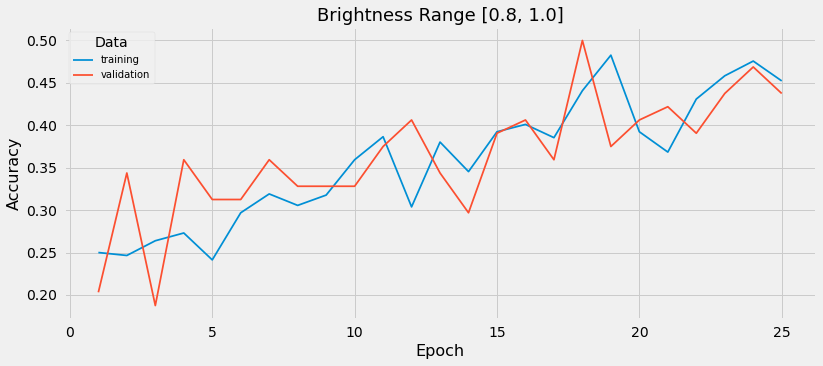

In [ ]:
for brightness in [[0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0]]:
    train_datagen = ImageDataGenerator(
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1./255,
            fill_mode='nearest',
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=45,
            zoom_range=0.1,
            brightness_range=brightness)
    train_generator_1 = train_datagen.flow_from_directory(
            'model_dataset/train/augment',
            target_size=(200, 200),
            batch_size=52,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator_2 = train_datagen.flow_from_directory(
            'model_dataset/train/no_augment',
            target_size=(200, 200),
            batch_size=12,
            class_mode='categorical',
            shuffle=True,
            seed=15)
    train_generator = myGenerator(train_generator_1, train_generator_2)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(5,activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=10, 
                        epochs=25, validation_data=valid_generator,
                        validation_steps=2, verbose=0)
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['accuracy']) + 1)],
        'accuracy':history.history['accuracy']})
        
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(history.history['val_accuracy']) + 1)],
        'accuracy':history.history['val_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12,5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Brightness Range {}'.format(brightness), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [ ]:
# Decisions:
# -Batch Size = 64
# -90 degree rotation (+ and -)
# -Flip vertical and horizontal
#     These give the full range of image rotation and the flipped
# -width_shift_range = 0.2
# -height_shift_range = 0.2
# -shear_range = 15
# -zoom_range = 0.1
# -brightness_range = [0.7,1.0]